# GPT Classification Tests

In this notebook I am testing how GPT classification works and what is it's predictions before the sentence ends, i.e. is it true that GPT already knows the outcome with a certain probability, but it get's really sure as the text ends. This is my version of the [Unsupervised Sentiment Neuron](https://openai.com/blog/unsupervised-sentiment-neuron/) from OpenAI applied on transformers.

In [96]:
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer, GPT2LMHeadModel
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
   
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange
from datasets import load_dataset

import os
import torch

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

from types import SimpleNamespace
from scipy.signal import savgol_filter
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
CGREYBG   = '\33[100m'
CREDBG    = '\33[41m'
CGREENBG  = '\33[42m'
CYELLOWBG = '\33[43m'
CBLUEBG   = '\33[44m'
CVIOLETBG = '\33[45m'
CBEIGE2  = '\33[46m'
CEND = '\033[0m'

color_by_stars = {
  0: CREDBG,
  1: CYELLOWBG,
  2: CBEIGE2,
  3: CVIOLETBG,
  4: CBLUEBG
}

color_names = [
  f"{color_by_stars[0]} {CEND}: 1 star",
  f"{color_by_stars[1]} {CEND}: 2 star",
  f"{color_by_stars[2]} {CEND}: 3 star",
  f"{color_by_stars[3]} {CEND}: 4 star",
  f"{color_by_stars[4]} {CEND}: 5 star",
]

def get_colored_help():
  return " ".join(color_names)

def get_colored_text(tokens, scores, h = True):
  _str = ""
  if h:
    _str = get_colored_help()
    _str += "\n"
  for t,s in zip(tokens, scores):
    _str += color_by_stars[s] + t + " "
  _str = _str[:-1] + CEND
  
  return _str


print(get_colored_text(
  ["In", "this", "world", "of", "fast", "mov", "ing" , "text"],
  [0, 1, 2, 3, 4, 2, 3, 1, 2]
))
print("target ->", color_names[2])

 : 1 star  : 2 star  : 3 star  : 4 star  : 5 star
In this world of fast mov ing text
target ->  : 3 star


In [58]:
def accuracy(logits, stars):
  acc_ = sum(logits.argmax(-1) == stars) / len(stars)
  return acc_

In [4]:
MAX_SEQLEN = 256
BATCH_SIZE = 64
GRAD_ACC_STEPS = 1 # effective batch size = 512
NUM_TRAIN_STEPS = 1000 * 16 # one epochs -> 200000 // 64 == 3125 so we train for ~5.12
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0
END_OF_TEXT = "<|endoftext|>"

# define the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.model_max_length = MAX_SEQLEN

In [5]:
# load dataset and remove useless columns
amazon_reviews = load_dataset('amazon_reviews_multi', 'en')
amazon_reviews.remove_columns_([
  'review_id', 'product_id', 'reviewer_id', 'review_title', 'language', 'product_category'
])
amazon_reviews

Reusing dataset amazon_reviews_multi (/home/npawdev/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/f3357bd271e187385a38574fe31b8fb10055303f67fa9fce55e84d08c4870efd)


DatasetDict({
    train: Dataset({
        features: ['stars', 'review_body'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['stars', 'review_body'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['stars', 'review_body'],
        num_rows: 5000
    })
})

In [6]:
data = amazon_reviews["train"][:10]
for text, stars in zip(data["review_body"], data["stars"]):
  print(text, "--->", stars)

Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process. ---> 1
the cabinet dot were all detached from backing... got me ---> 1
I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped and boxed. ---> 1
This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support

In [7]:
if not os.path.exists("./all_reviews.txt"):
  # write a complete file with text and train a sentence piece tokeniser
  with open("./all_reviews.txt", "w") as f:
    for x in ["train", "test", "validation"]:
      f.write("\n".join(amazon_reviews_with_eos[x]["review_body"]))

  # sentencepiece
  SentencePieceTrainer.train(f'''--input=all_reviews.txt \
  --model_prefix=ar \
  --vocab_size=1999
  ''')

In [8]:
class SentencePieceTokenizerWrapper():
  def __init__(self, path = "ar.model"):
    tokenizer = SentencePieceProcessor()
    tokenizer.load(path)
    self.tokenizer = tokenizer
    self.eot_id = tokenizer.vocab_size()
    self.eot_token = END_OF_TEXT
    self.vocab_size = tokenizer.vocab_size() + 1
    
  def decode_ids(self, ids):
    if isinstance(ids[0], int):
      ids = [ids]
    ids = np.array(ids).astype(int)
    tokens = []
    for x in ids:
      if self.eot_id in x:
        x = x[:np.not_equal(x, self.eot_id).argmin()]
      tokens.append(x.tolist())
    return tokens
  
  def decode(self, ids):
    tokens = self.decode_ids(ids)
    tokens = [self.tokenizer.decode_ids(x) for x in tokens]
    return tokens
    
  def __call__(self, sentences, maxlen = MAX_SEQLEN, add_eot = False):
    if isinstance(sentences, str):
      sentences = [sentences]
      
    B  = len(sentences)
    tokens = [self.tokenizer.encode_as_ids(t) for t in sentences]
    tokens_lenghts = [len(x) for x in tokens]
    
    # minus 1 because we append EOT_ID
    max_len_can_have = MAX_SEQLEN - 1 if add_eot else MAX_SEQLEN
    max_len = min(max(tokens_lenghts), max_len_can_have)
    tokenized = np.ones((B, max_len)) * self.eot_id
    for i,t in enumerate(tokens):
      tokenized[i, :tokens_lenghts[i]] = tokens[i][:max_len]
    
    if add_eot:
      tokenized = np.hstack([tokenized, np.ones((B, 1)) * self.eot_id])
    input_ids = tokenized.astype(int)
    
    attention_mask = np.zeros((B, max_len + 1 if add_eot else max_len))
    for i,l in enumerate(tokens_lenghts):
      attention_mask[i, :l+1] = 1
    attention_mask = attention_mask.astype(int)
    return {
      "input_ids": torch.from_numpy(input_ids).long(),
      "attention_mask": torch.from_numpy(attention_mask).long()
    }
    
  
tokenizer = SentencePieceTokenizerWrapper()
print("Vocab Size:", tokenizer.vocab_size)
sample = tokenizer(["Unless you have this jam", "life is? hard"], add_eot = True)
print(sample)
print(tokenizer.decode_ids([123, 423, 342, 123, 123]))

Vocab Size: 2000
{'input_ids': tensor([[1382,  644,   47,   37,   27,  401,  281, 1999],
        [ 680,   20,  324,  239, 1999, 1999, 1999, 1999]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0]])}
[[123, 423, 342, 123, 123]]


In [9]:
tokenized = tokenizer(data["review_body"])
{k:v.size() for k,v in tokenized.items()}

{'input_ids': torch.Size([10, 175]), 'attention_mask': torch.Size([10, 175])}

In [10]:
data["stars"]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [11]:
# Max token ids should be a sequence of [ ... 50256 ... ]
# and (Max token ids - 1) should not contain 50256 in output list
print("Max token ids:", tokenized["input_ids"][torch.arange(10), tokenized["input_ids"].argmax(-1)])
print("Max token ids - 1:", tokenized["input_ids"][torch.arange(10), tokenized["input_ids"].argmax(-1) - 1])

Max token ids: tensor([1828, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999])
Max token ids - 1: tensor([  6,  66,   3,  43, 192,   3,   3,   3,   3,   3])


In [12]:
tokenizer.decode_ids([[3],[66],[3],[43],[192],[3],[3],[3],[3],[3]]), tokenizer.decode([[3],[66],[3],[43],[192],[3],[3],[3],[3],[3]])

([[3], [66], [3], [43], [192], [3], [3], [3], [3], [3]],
 ['.', 'me', '.', '!', ')', '.', '.', '.', '.', '.'])

# Test Setup

There are 2 different methods of testing:
1. When model is trained directly on the stars classification at the end of the sequence using `<|endoftext|>` tag
2. When model is first trained as a GPT to predict next token and then body is frozen and trained for classification

This is how the evaluation works:
1. We train network on the `train` split
2. We take the `test` split and pass it through the classification head:
  - In either case the final accuracy will be compared using `<|endoftext|>` tag
  - However we will pass all the tokens through the model and store results for evaluation

### Method 1

In this method we directly train a classifier for stars

In [12]:
class GPT2ClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    model_config = GPT2Config(
      vocab_size=tokenizer.vocab_size,
      n_positions=MAX_SEQLEN,
      n_ctx=MAX_SEQLEN,
      n_embd=128,
      n_layer=6,
      n_head=2,

      num_labels = 5,
      pad_token_id = tokenizer.eot_id,
      bos_token_id = tokenizer.eot_id,
      eos_token_id = tokenizer.eot_id,
    )
    self.body = GPT2Model(model_config)
    self.linear = self.get_linear(model_config)
    self.model_config = model_config
    
  def get_linear(self, model_config):
    # define linear and initialise weights
    linear = nn.Linear(model_config.n_embd, model_config.num_labels)
    linear.weight.requires_grad = False
    linear.bias.requires_grad = False
    linear.weight.normal_(std = 0.02)
    linear.bias.zero_()
    linear.weight.requires_grad = True
    linear.bias.requires_grad = True
    return linear
  
  def num_parameters(self):
    return sum(p.numel() for p in self.parameters())
    
  def forward(self, input_data):
    B, N = input_data["input_ids"].shape
    eot_tokens = input_data["input_ids"].argmax(-1)
    output = self.body(**input_data).last_hidden_state
    eot_logits = output[torch.arange(B), eot_tokens]
    logits = self.linear(eot_logits)
    return logits

only_classification_model = GPT2ClassifierModel()
only_classification_model.num_parameters()

1479301

In [14]:
only_classification_model = only_classification_model.to(device)
optim = torch.optim.Adam(only_classification_model.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
dl = DataLoader(
  amazon_reviews["train"],
  shuffle = True,
  batch_size = BATCH_SIZE,
)


def one_iteration(raw_data, mode = "train"):
  input_data = tokenizer(raw_data["review_body"], add_eot = True)
  input_data = {k:v.to(device) for k,v in input_data.items()}
  targets = raw_data["stars"].to(device).long() - 1 # 
  # pass through the network
  is_train = mode == "train"
  with torch.set_grad_enabled(is_train):
    logits = only_classification_model(input_data)
    output = []
  
    if is_train:
      loss = F.cross_entropy(logits, targets)

      # train network
      optim.zero_grad()
      loss.backward()
      optim.step()
      
      output = [loss.item()]
      
    acc = accuracy(logits.detach().to("cpu"), targets.to("cpu"))
    output = [acc, logits] + output
    return output

In [16]:
# Train the network
optim.zero_grad()
train_losses_over_steps = [-1]
train_acc_over_steps = [-1]
pbar = trange(NUM_TRAIN_STEPS)
for _i_step in pbar:
  pbar.set_description(
    f"Loss: {np.mean(train_losses_over_steps[-50:]):.3f} | Acc.: {np.mean(train_acc_over_steps[-50:]):.3f}"
  )

  # get data
  raw_data = next(iter(dl))
  output = one_iteration(raw_data)
  train_losses_over_steps.append(output[-1])
  train_acc_over_steps.append(output[0])

Loss: 1.090 | Acc.: 0.536: 100%|██████████| 16000/16000 [16:40<00:00, 15.99it/s]


In [266]:
torch.save(only_classification_model.state_dict(), "./weights/m1.pt")
del only_classification_model

Text(0.5, 0, 'iteration')

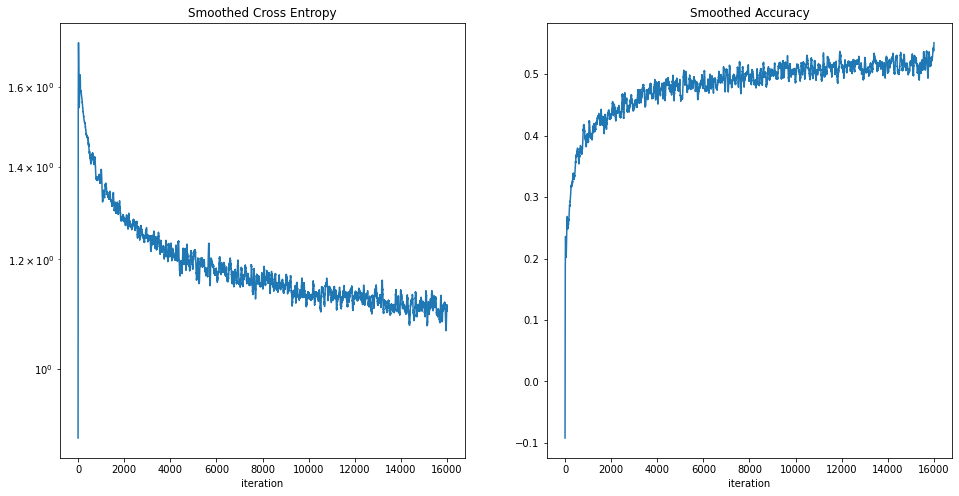

In [22]:
train_losses_smooth = savgol_filter(train_losses_over_steps, 201, 7)
train_acc_smooth = savgol_filter(train_acc_over_steps, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_losses_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed Cross Entropy')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_acc_smooth)
ax.set_title('Smoothed Accuracy')
ax.set_xlabel('iteration')

In [269]:
only_classification_model = GPT2ClassifierModel()
only_classification_model.load_state_dict(torch.load("./weights/m1.pt"))

<All keys matched successfully>

In [30]:
dl = DataLoader(
  amazon_reviews["test"],
  shuffle = True,
  batch_size = BATCH_SIZE,
)
only_classification_model.eval()
test_prediction = []
test_label = []
for x in dl:
  logits = one_iteration(x, "test")[1]
  targets = x["stars"].to(device).long() - 1 # 
  
  test_prediction.extend(logits.argmax(-1).tolist())
  test_label.extend(targets.tolist())

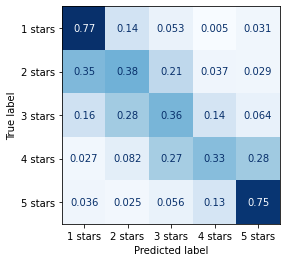

In [58]:
cm = confusion_matrix(test_label, test_prediction).astype(float)
cm /= np.sum(cm, axis = 1)
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=[f"{i+1} stars" for i in range(5)],
)
disp.plot(cmap='Blues', xticks_rotation='horizontal', colorbar = False, )

From the above plot we can see that model is really sure at the corners but really bad at the central part of this.

Next we perform token by token prediction and see how it performs.

In [192]:
BATCH_SIZE = 64

dl = DataLoader(
  amazon_reviews["test"],
  batch_size = BATCH_SIZE,
)
only_classification_model.eval()
all_tokens = []
all_tokens_max = []
all_labels = []
for x in dl:
  input_data = tokenizer(x["review_body"])
  input_data = {k:v.to(device) for k,v in input_data.items()}
  targets = x["stars"].long() - 1 # 
  
  with torch.no_grad():
    last_hidden_state = only_classification_model.body(**input_data).last_hidden_state
    all_token_logits = only_classification_model.linear(last_hidden_state).argmax(-1)
    
  # 1. log the tokens
  this_tokens = [tokenizer.decode_ids(x)[0] for x in input_data["input_ids"].tolist()]
  this_tokens_expanded = [
    [tokenizer.tokenizer.decode_ids([x]) for x in y]
    for y in this_tokens
  ]
  all_tokens.extend(this_tokens_expanded)
  
  # 2. log the scores per token
  all_token_logits = all_token_logits.cpu()
  this_tokens_max = []
  for i, logits in enumerate(all_token_logits):
    max_idx = torch.ne(input_data["input_ids"][i], tokenizer.eot_id).long().argmin() - 1
    max_idx = max_idx.item()
    this_tokens_max.append(logits[:max_idx].tolist())
  all_tokens_max.extend(this_tokens_max)
  
  # 3. log the targets
  all_labels.extend(targets.tolist())

In [193]:
all_tokens[-1], all_tokens[123]

(['Just',
  'what',
  'I',
  'needed',
  '!',
  'Perfect',
  'for',
  'we',
  's',
  'ter',
  'n',
  'them',
  'e',
  'party',
  '.'],
 ['Item', 'did', 'not', 'fit', 'my', 'car', 'properly', '.'])

In [194]:
all_tokens_max[-1], all_tokens_max[123]

([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0])

In [195]:
all_labels[-1], all_labels[123]

(4, 0)

In [270]:
print(get_colored_help())
for _ in range(5):
  print("-" * 70)
  idx = np.random.randint(len(all_tokens))
  print(get_colored_text(all_tokens[idx], all_tokens_max[idx], False))
  print("target ->", color_names[all_labels[idx]])
  

 : 1 star  : 2 star  : 3 star  : 4 star  : 5 star
----------------------------------------------------------------------
They were beautiful and worked great for the a g ap e items I needed them for
target ->  : 5 star
----------------------------------------------------------------------
I did not order this app . please remove it
target ->  : 1 star
----------------------------------------------------------------------
This case protect s pretty well . Bought it for my son ' s 6 x and he like s it
target ->  : 4 star
----------------------------------------------------------------------
I bought the surprise shirt for gra nd par ent s , but was sent one for an a un t . I was plan ning on su r p ri s ing them with this shirt to m or r ow in a cute way , but now I have to post p one the get together until I receive the correct item sent hope ful ly right this time
target ->  : 1 star
----------------------------------------------------------------------
E ach of the mount s are sturdy 

From the above you can see beautiful visualisation of the text and corresponding scores.

### Method 2

In this method we first train a GPT and then finetune by replacing the lm-head.

In [49]:
# copying config from above
gpt_lm_config = GPT2Config(
  vocab_size=tokenizer.vocab_size,
  n_positions=MAX_SEQLEN,
  n_ctx=MAX_SEQLEN,
  n_embd=128,
  n_layer=6,
  n_head=2,

  num_labels = 5,
  pad_token_id = tokenizer.eot_id,
  bos_token_id = tokenizer.eot_id,
  eos_token_id = tokenizer.eot_id,
)


class GPT2(GPT2LMHeadModel):
  def __init__(self, config):
    super().__init__(config)
    
  def forward(self, input_ids, attention_mask = None, labels = None, only_hidden_states = False, **kwargs):
    B, S = input_ids.shape
    transformer_outputs = self.transformer(input_ids, attention_mask = attention_mask, **kwargs)
    hidden_states = transformer_outputs[0]
    if only_hidden_states:
      return hidden_states
    lm_logits = self.lm_head(hidden_states)
    loss = None
    if labels != None:
      # loss only non-pad locations
      non_pad = torch.ne(input_ids, tokenizer.eot_id)[:, :-1].reshape(-1).to(device) # [B * S,]

      # Shift so that tokens < n predict n
      shift_logits = lm_logits[..., :-1, :].contiguous()
      shift_labels = labels[..., 1:].contiguous()
      # Flatten the tokens
      loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
      loss = loss_fct(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1)
      )
      loss = loss[non_pad].mean()
    return CausalLMOutputWithCrossAttentions(
      logits = lm_logits,
      loss = loss
    )

gpt2 = GPT2(gpt_lm_config)

In [14]:
output = gpt2(
  input_ids = torch.Tensor([0, 312, 23, 1234, 1999, 1999]).long().unsqueeze(0),
  labels = torch.Tensor([0, 312, 23, 1234, 1999, 1999]).long().unsqueeze(0)
)
print(output.keys())
print(output.logits.shape)
print(output.loss)

odict_keys(['loss', 'logits'])
torch.Size([1, 6, 2000])
tensor(7.4591, grad_fn=<MeanBackward0>)


In [15]:
input_data = tokenizer("Arrived broken. Manufacturer defect", add_eot = False)
beam_outputs = gpt2.generate(
  input_ids = input_data["input_ids"],
  max_length = 25,
  do_sample = True,
  top_k=40,
  top_p=0.95,
  num_return_sequences=4,
  early_stopping = True
).cpu().numpy()
beam_strs = tokenizer.decode(beam_outputs)

input_data["input_ids"]

tensor([[1510,  447,    3,  264,  165,   94,  100,  304,   18,  149,   41,  199,
          100,  655]])

In [16]:
tokenizer.decode(beam_outputs.tolist())

['Arrived broken. Manufacturer defect4 stretch daily speaker Pretty Much You 3 pieces thin summer',
 'Arrived broken. Manufacturer defect packaging bathroom tree reason dutyU Only need chew need at',
 'Arrived broken. Manufacturer defect To flash do leatherped problems Had going00 everywhere customer',
 'Arrived broken. Manufacturer defectectma larger leather crazyside double version version can Had']

In [83]:
gpt2 = gpt2.to(device)
optim = torch.optim.Adam(gpt2.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
dl = DataLoader(
  amazon_reviews["train"],
  shuffle = True,
  batch_size = BATCH_SIZE,
)


def one_iteration(raw_data, mode = "train"):
  input_data = tokenizer(raw_data["review_body"], add_eot=False)
  input_data = {k:v.to(device) for k,v in input_data.items()}
  targets = raw_data["stars"].to(device).long() - 1 # 
  
  # pass through the network
  is_train = mode == "train"
  gpt2.train(is_train) # whether it is in eval or training mode
  with torch.set_grad_enabled(is_train):
    out = gpt2(**input_data, labels = input_data["input_ids"])
    output = []
  
    if is_train:
      # train network
      optim.zero_grad()
      out.loss.backward()
      optim.step()
    output = [out.logits, out.loss.item()]
    return output
  
def generate_samples():
  gpt2.cpu()
  gpt2.eval()
  input_data = tokenizer("Arrived broken. Manufacturer defect. Two of the legs of the base were not")
  beam_outputs = gpt2.generate(
    input_ids = input_data["input_ids"],
    max_length = 30,
    do_sample = True,
    top_k=40,
    top_p=0.95,
    num_return_sequences=6
  ).cpu().numpy()
  beam_strs = tokenizer.decode(beam_outputs)
  return beam_strs

In [18]:
SAMPLE_EVERY = NUM_TRAIN_STEPS // 6

# Train the network
optim.zero_grad()
train_losses_over_steps = [-1]
pbar = trange(NUM_TRAIN_STEPS)
for _i_step in pbar:
  pbar.set_description(f"Loss: {np.mean(train_losses_over_steps[-50:]):.3f}")

  # get data
  raw_data = next(iter(dl))
  output = one_iteration(raw_data)
  train_losses_over_steps.append(output[-1])
  
  if _i_step % SAMPLE_EVERY == 0:
    beam_strs = generate_samples()
    print(f"--- Iteration: {_i_step} ---")
    print("\n".join(beam_strs))
    gpt2.to(device)
    gpt2.train()

beam_strs = generate_samples()
print(f"--- Iteration: {_i_step} ---")
print("\n".join(beam_strs))

Loss: 5.467:   0%|          | 3/16000 [00:00<33:59,  7.85it/s] 

--- Iteration: 0 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not nicely print measure blanketctor
Arrived broken. Manufacturer defect. Two of the legs of the base were not weird pri tooward thin
Arrived broken. Manufacturer defect. Two of the legs of the base were notv package lightweight bathroom comment
Arrived broken. Manufacturer defect. Two of the legs of the base were not Never separate0 Fast basically
Arrived broken. Manufacturer defect. Two of the legs of the base were not instead list appreciate effect glad
Arrived broken. Manufacturer defect. Two of the legs of the base were not separate take odd the Does


Loss: 5.854:  17%|█▋        | 2669/16000 [02:54<16:10, 13.74it/s]

--- Iteration: 2666 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not buting toinge
Arrived broken. Manufacturer defect. Two of the legs of the base were not you  I is have
Arrived broken. Manufacturer defect. Two of the legs of the base were not in the care a
Arrived broken. Manufacturer defect. Two of the legs of the base were not the sameed was so
Arrived broken. Manufacturer defect. Two of the legs of the base were not you is they was.
Arrived broken. Manufacturer defect. Two of the legs of the base were not buts! I 


Loss: 5.339:  33%|███▎      | 5335/16000 [05:49<13:21, 13.31it/s]

--- Iteration: 5332 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not to not to get my
Arrived broken. Manufacturer defect. Two of the legs of the base were not a ding and
Arrived broken. Manufacturer defect. Two of the legs of the base were not a the price, as
Arrived broken. Manufacturer defect. Two of the legs of the base were not very disappointed it. Very
Arrived broken. Manufacturer defect. Two of the legs of the base were not the product.
Arrived broken. Manufacturer defect. Two of the legs of the base were not not ados


Loss: 5.101:  50%|█████     | 8000/16000 [08:43<09:59, 13.34it/s]

--- Iteration: 7998 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not ading a g
Arrived broken. Manufacturer defect. Two of the legs of the base were not so you need, it
Arrived broken. Manufacturer defect. Two of the legs of the base were not the picture on the one
Arrived broken. Manufacturer defect. Two of the legs of the base were not have a few bur
Arrived broken. Manufacturer defect. Two of the legs of the base were not on the case it will
Arrived broken. Manufacturer defect. Two of the legs of the base were not very great.


Loss: 4.961:  67%|██████▋   | 10667/16000 [11:37<06:19, 14.07it/s]

--- Iteration: 10664 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not as good time I thought
Arrived broken. Manufacturer defect. Two of the legs of the base were not very small and a f
Arrived broken. Manufacturer defect. Two of the legs of the base were not too in the case.
Arrived broken. Manufacturer defect. Two of the legs of the base were not buy it is a few
Arrived broken. Manufacturer defect. Two of the legs of the base were not great.
Arrived broken. Manufacturer defect. Two of the legs of the base were not have to return, I


Loss: 4.858:  83%|████████▎ | 13334/16000 [14:31<03:05, 14.37it/s]

--- Iteration: 13330 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not a lot. Will not
Arrived broken. Manufacturer defect. Two of the legs of the base were not very well.
Arrived broken. Manufacturer defect. Two of the legs of the base were not not the color.
Arrived broken. Manufacturer defect. Two of the legs of the base were not a bit well. My
Arrived broken. Manufacturer defect. Two of the legs of the base were not to a lot.
Arrived broken. Manufacturer defect. Two of the legs of the base were not. This product was the


Loss: 4.771: 100%|██████████| 16000/16000 [17:25<00:00, 15.30it/s]

--- Iteration: 15996 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not worth the ste.
Arrived broken. Manufacturer defect. Two of the legs of the base were not a lot of the color
Arrived broken. Manufacturer defect. Two of the legs of the base were not as you. I can
Arrived broken. Manufacturer defect. Two of the legs of the base were not.
Arrived broken. Manufacturer defect. Two of the legs of the base were notek at the g
Arrived broken. Manufacturer defect. Two of the legs of the base were not a new box. So


--- Iteration: 15999 ---
Arrived broken. Manufacturer defect. Two of the legs of the base were not. The same quality is
Arrived broken. Manufacturer defect. Two of the legs of the base were not so a good time
Arrived broken. Manufacturer defect. Two of the legs of the base were not a teh
Arrived broken. Manufacturer defect. Two of the legs of the base were not a little long.
Arrived broken. Manufacturer defect. Two of the legs of the base were not in the money.
Arrived broken. Manufacturer defect. Two of the legs of the base were notetufe


In [25]:
torch.save(gpt2.state_dict(), "./weights/m2_gpt.pt")
del gpt2

Text(0.5, 0, 'iteration')

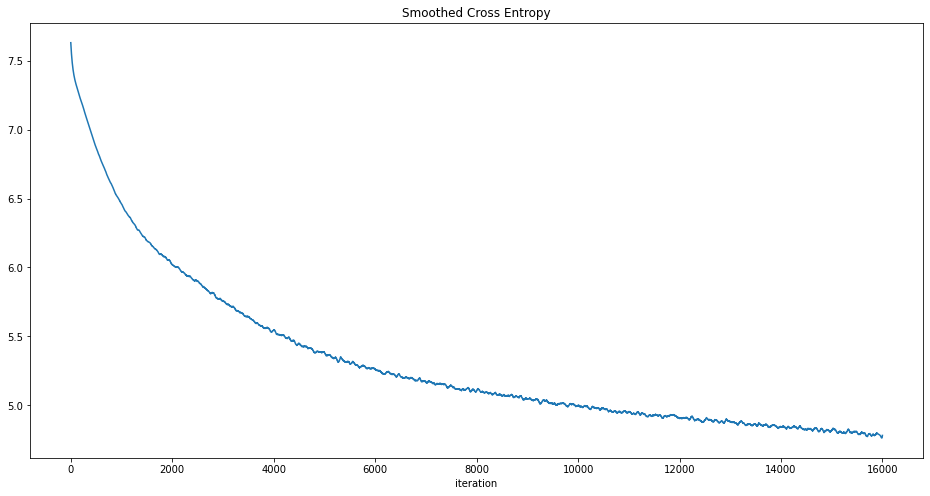

In [24]:
train_losses_smooth = savgol_filter(train_losses_over_steps[1:], 201, 7)

plt.figure(figsize=(16,8))
plt.plot(train_losses_smooth)
plt.title('Smoothed Cross Entropy')
plt.xlabel('iteration')

In [81]:
gpt2 = GPT2(gpt_lm_config)
gpt2.load_state_dict(torch.load("./weights/m2_gpt.pt"))

<All keys matched successfully>

In [84]:
dl = DataLoader(
  amazon_reviews["test"],
  shuffle = True,
  batch_size = BATCH_SIZE,
)
gpt2.eval()
test_loss = []
for x in dl:
  logits, loss = one_iteration(x, "test")
  test_loss.append(loss)
  
print('Test Loss:', np.mean(test_loss))

Test Loss: 4.720117436179632


Now from the above generated samples you can see that it does indeed learn something and the loss does decrease as expected. Also this model has not overfit to the training data as test loss is good.

Next step is fine-tuning the model and seeing how it performs.

In [85]:
class GPT2FineTuned(nn.Module):
  def __init__(self, gpt2, num_classes = 5):
    super().__init__()
    self.model_config = gpt2.config
    self.body = gpt2
    self.linear = nn.Linear(self.model_config.n_embd, num_classes)
    
    for p in self.body.parameters():
      p.requires_grad = False
    
  @torch.no_grad()
  def pass_through_body(self, input_data):
    self.body.eval()
    return self.body(**input_data, only_hidden_states = True) # output = logits
    
  def num_parameters(self):
    return sum(p.numel() for p in self.parameters())
    
  def forward(self, input_data):
    B, N = input_data["input_ids"].shape
    eot_tokens = input_data["input_ids"].argmax(-1)
    output = self.pass_through_body(input_data)
    eot_logits = output[torch.arange(B), eot_tokens]
    logits = self.linear(eot_logits)
    return logits
  
  
gpt2classifier = GPT2FineTuned(gpt2)
gpt2classifier = gpt2classifier.to(device)

In [86]:
input_data = tokenizer(raw_data["review_body"], add_eot=False)
input_data = {k:v.to(device) for k,v in input_data.items()}

In [87]:
gpt2classifier(input_data).shape

torch.Size([64, 5])

In [88]:
# only need to train new head parameters
optim = torch.optim.Adam(gpt2classifier.linear.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
dl = DataLoader(
  amazon_reviews["train"],
  shuffle = True,
  batch_size = BATCH_SIZE,
)


def one_iteration(raw_data, mode = "train"):
  input_data = tokenizer(raw_data["review_body"], add_eot=True)
  input_data = {k:v.to(device) for k,v in input_data.items()}
  targets = raw_data["stars"].to(device).long() - 1 # 
  
  # pass through the network
  is_train = mode == "train"
  gpt2.train(is_train) # whether it is in eval or training mode
  with torch.set_grad_enabled(is_train):
    logits = gpt2classifier(input_data)
    output = []
    loss = F.cross_entropy(logits, targets)
  
    if is_train:
      # train network
      optim.zero_grad()
      loss.backward()
      optim.step()

    acc = accuracy(logits.detach().to("cpu"), targets.to("cpu")).item()
    output = [acc, logits, loss.item()]
    return output


In [89]:
# Train the network
optim.zero_grad()
train_losses_over_steps = [-1]
train_acc_over_steps = [-1]
pbar = trange(NUM_TRAIN_STEPS * 3)
for _i_step in pbar:
  pbar.set_description(
    f"Loss: {np.mean(train_losses_over_steps[-50:]):.3f} | Acc.: {np.mean(train_acc_over_steps[-50:]):.3f}"
  )

  # get data
  raw_data = next(iter(dl))
  output = one_iteration(raw_data)
  train_losses_over_steps.append(output[-1])
  train_acc_over_steps.append(output[0])

Loss: 1.529 | Acc.: 0.333: 100%|██████████| 48000/48000 [17:05<00:00, 46.80it/s]


Text(0.5, 0, 'iteration')

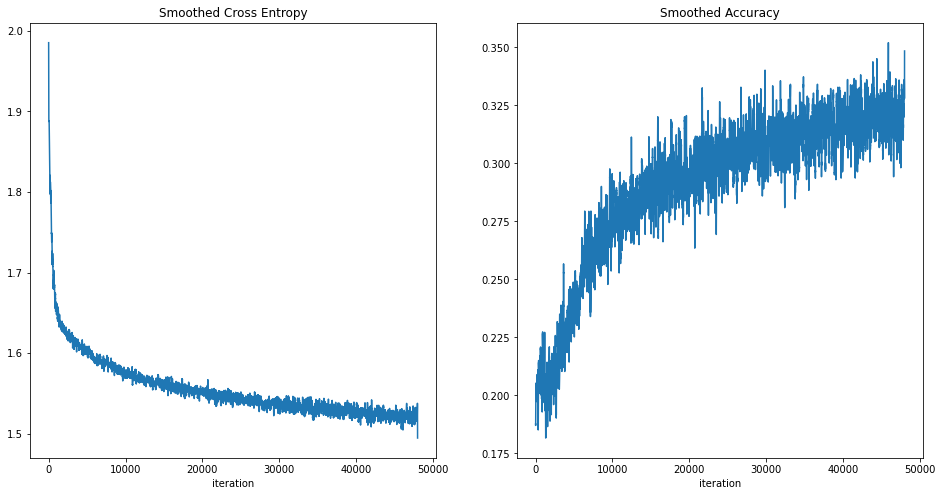

In [91]:
train_losses_smooth = savgol_filter(train_losses_over_steps[1:], 201, 7)
train_acc_smooth = savgol_filter(train_acc_over_steps[1:], 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_losses_smooth)
# ax.set_yscale('log')
ax.set_title('Smoothed Cross Entropy')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_acc_smooth)
ax.set_title('Smoothed Accuracy')
ax.set_xlabel('iteration')

In [93]:
torch.save(gpt2classifier.state_dict(), "./weights/m2_fine_tuned.pt")

In [94]:
dl = DataLoader(
  amazon_reviews["test"],
  shuffle = True,
  batch_size = BATCH_SIZE,
)
gpt2classifier.eval()
test_prediction = []
test_label = []
for x in dl:
  logits = one_iteration(x, "test")[1]
  targets = x["stars"].to(device).long() - 1 # 
  
  test_prediction.extend(logits.argmax(-1).tolist())
  test_label.extend(targets.tolist())

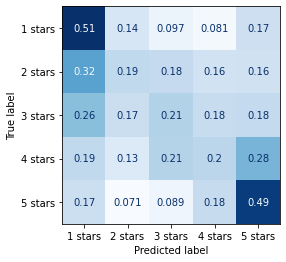

In [97]:
cm = confusion_matrix(test_label, test_prediction).astype(float)
cm /= np.sum(cm, axis = 1)
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=[f"{i+1} stars" for i in range(5)],
)
disp.plot(cmap='Blues', xticks_rotation='horizontal', colorbar = False, )

From the above Confusion Matrix you can see that the model is very confused despite being trained for 48k steps.

In [104]:
BATCH_SIZE = 64

dl = DataLoader(
  amazon_reviews["test"],
  batch_size = BATCH_SIZE,
)
gpt2classifier.eval()
all_tokens = []
all_tokens_max = []
all_labels = []
for x in dl:
  input_data = tokenizer(x["review_body"])
  input_data = {k:v.to(device) for k,v in input_data.items()}
  targets = x["stars"].long() - 1 # 
  
  with torch.no_grad():
    last_hidden_state = gpt2classifier.body(**input_data, only_hidden_states = True)
    all_token_logits = gpt2classifier.linear(last_hidden_state).argmax(-1)
    
  # 1. log the tokens
  this_tokens = [tokenizer.decode_ids(x)[0] for x in input_data["input_ids"].tolist()]
  this_tokens_expanded = [
    [tokenizer.tokenizer.decode_ids([x]) for x in y]
    for y in this_tokens
  ]
  all_tokens.extend(this_tokens_expanded)
  
  # 2. log the scores per token
  all_token_logits = all_token_logits.cpu()
  this_tokens_max = []
  for i, logits in enumerate(all_token_logits):
    max_idx = torch.ne(input_data["input_ids"][i], tokenizer.eot_id).long().argmin() - 1
    max_idx = max_idx.item()
    this_tokens_max.append(logits[:max_idx].tolist())
  all_tokens_max.extend(this_tokens_max)
  
  # 3. log the targets
  all_labels.extend(targets.tolist())

In [105]:
print(get_colored_help())
for _ in range(5):
  print("-" * 70)
  idx = np.random.randint(len(all_tokens))
  print(get_colored_text(all_tokens[idx], all_tokens_max[idx], False))
  print("target ->", color_names[all_labels[idx]])

 : 1 star  : 2 star  : 3 star  : 4 star  : 5 star
----------------------------------------------------------------------
A must read for all who are looking for trans for m ation in their think ing . A great in s p ir ation in mo ving from f e ar to free d om . A d d to your l ib r ary today
target ->  : 5 star
----------------------------------------------------------------------
B est thing I purchased for my  s al t wa ter tank . . T ru s t you go n na needs this to get a better idea how much  s al t is in your tank . Would highly recommend it
target ->  : 5 star
----------------------------------------------------------------------
Just can ' t get use to the lack of taste with this c e y lo n c in na mon . I have to use so much to get any taste at all . This is the first c e y lo n I ' ve tried so I can ' t compare . Just not impressed . I a g re e with some others that it taste more like red hot can d y smell s . H op e I can find some that has some flavor . I really don ' t want